In [1]:
%%capture
!pip install segmentation-models

In [2]:
%%capture
!pip install tqdm==2.2.3

In [35]:
import tensorflow
import os, tqdm
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
# import segmentation_models as sm
from PIL import Image
# from tensorflow import keras
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler

# List the devices to see if the GPU is being used
physical_devices = tensorflow.config.list_physical_devices('GPU')
if physical_devices:
    print(f"Using GPU: {physical_devices}")
else:
    print("No GPU detected, using CPU.")

IMG_PATH = "/Users/loan/Desktop/Segmentation-main/train_val/images" #path to original images
MASK_PATH = "/Users/loan/Desktop/Segmentation-main/train_val/masks"

No GPU detected, using CPU.


In [4]:
image_data = []

images = sorted(os.listdir(IMG_PATH))
for i, image_name in enumerate(images):
    #if image_name.endswith('.jpg'):
    image = cv2.imread(IMG_PATH+"/"+image_name, 1)
    image = np.array(image)/255
    image = cv2.resize(image, (256, 256))
    image_data.append(image)

In [5]:
mask_data = []

masks = sorted(os.listdir(MASK_PATH))
for i, mask_name in enumerate(masks):
    #if image_name.endswith('.jpg'):
    mask = cv2.imread(MASK_PATH+"/"+mask_name, 1)
    mask = np.array(mask)
    mask = cv2.resize(mask, (256, 256))
    mask_data.append(mask)

In [6]:
image_data = np.array(image_data)
# mask_data = np.array(mask_data)

In [7]:
image_data.shape, 
# mask_data.shape

((1525, 256, 256, 3),)

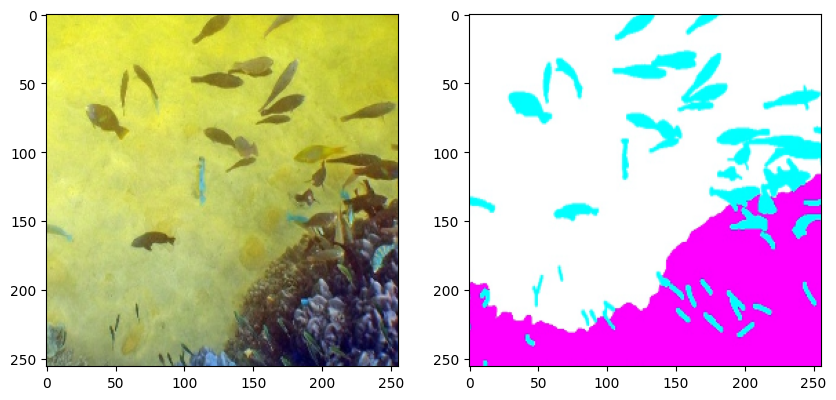

In [8]:
import random
sample = random.randint(0, len(image_data))
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(image_data[sample])
plt.subplot(122)
plt.imshow(mask_data[sample])
plt.show()

In [9]:
object_category_rgb = {
    "Background": [0, 0, 0], 
    "Human divers": [0, 0, 1], 
    "Aquatic plants and sea-grass": [0, 1, 0], 
    "Wrecks and ruins": [0, 1, 1], 
    "Robots (AUVs/ROVs/instruments)": [1, 0, 0], 
    "Reefs and invertebrates": [1, 0, 1], 
    "Fish and vertebrates": [1, 1, 0], 
    "Sea-floor and rocks": [1, 1, 1]
}


In [10]:
# Create a mapping from RGB to a single-channel integer
rgb_to_single_channel = {tuple(v): i for i, v in enumerate(object_category_rgb.values())}

def rgb_to_single_channel_mask(rgb_mask):
    # Initialize a single channel mask with the same height and width as the RGB mask
    single_channel_mask = np.zeros((rgb_mask.shape[0], rgb_mask.shape[1]), dtype=np.uint8)

    # Iterate over each RGB color and map it to the corresponding single-channel integer
    for rgb, label in rgb_to_single_channel.items():
        # Find all pixels in the RGB mask that match the current color
        mask = np.all(rgb_mask == np.array(rgb) * 255, axis=-1)  # Multiply by 255 to match 0/255 scale
        # Assign the corresponding label value to the single-channel mask
        single_channel_mask[mask] = label
    
    return single_channel_mask

    # Ensure output folder exists

labels = []
# Iterate over all files in the mask folder
for mask in tqdm.tqdm(mask_data):
    single_channel_mask = rgb_to_single_channel_mask(mask)

    labels.append(single_channel_mask)


In [11]:
labels = np.array(labels)

In [12]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint8)

In [13]:
labels.shape

(1525, 256, 256)

In [14]:
sample = 455

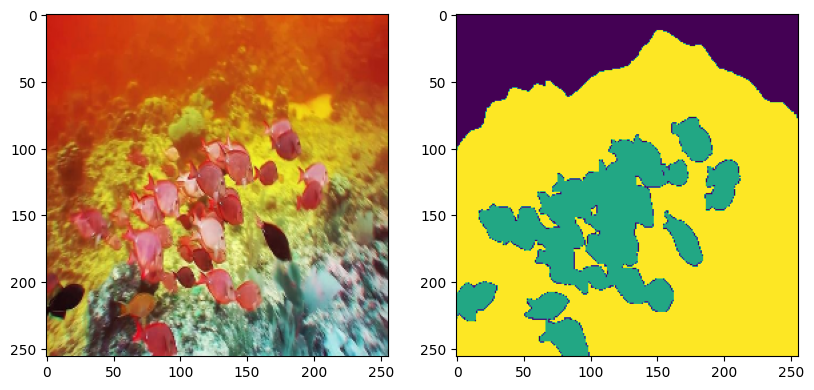

(256, 256)


In [15]:
sample = random.randint(0, len(labels))
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(image_data[sample])
plt.subplot(132)
# plt.imshow(mask_data[sample])
# plt.subplot(133)
plt.imshow(labels[sample])
plt.show()
print(labels[sample].shape)

In [16]:
from keras.utils import to_categorical

num_classes = len(np.unique(labels))
labels_cat = to_categorical(labels, num_classes=num_classes)

In [17]:
labels_cat.shape

(1525, 256, 256, 8)

In [18]:
from sklearn.model_selection import train_test_split
image_train, image_val, mask_train, mask_val = train_test_split(image_data, labels_cat, test_size=0.2, random_state=42)

for i in [image_train, image_val, mask_train, mask_val]:
    print(i.shape)


(1220, 256, 256, 3)
(305, 256, 256, 3)
(1220, 256, 256, 8)
(305, 256, 256, 8)


In [19]:
del labels
del labels_cat

In [20]:
n_classes=8
activation='softmax'

LR = 0.0001
optim = tensorflow.keras.optimizers.Adam(LR)

metrics = [sm.metrics.IOUScore, sm.metrics.FScore(threshold=0.5)]

In [32]:
import os
import tensorflow as tf
import segmentation_models as sm

# Force l'utilisation de vos poids locaux en modifiant temporairement le code de get_file
WEIGHTS_PATH = '/Users/loan/Desktop/Segmentation-main/resnet34_imagenet_1000_no_top.h5'

# Sauvegardez la fonction originale
original_get_file = tf.keras.utils.get_file

# Créez une fonction de remplacement qui retourne votre fichier local
def custom_get_file(fname, *args, **kwargs):
    if 'resnet34_imagenet_1000_no_top.h5' in fname:
        print(f"Utilisation du fichier local: {WEIGHTS_PATH}")
        return WEIGHTS_PATH
    return original_get_file(fname, *args, **kwargs)

# Remplacez temporairement la fonction
tf.keras.utils.get_file = custom_get_file

# Définissez votre modèle normalement avec encoder_weights='imagenet'
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# Prétraitez vos données
image_train = preprocess_input(image_train)
image_val = preprocess_input(image_val)

# Définissez le modèle avec encoder_weights='imagenet'
# Notre fonction modifiée interceptera l'appel pour télécharger les poids
model = sm.Unet(
    BACKBONE, 
    encoder_weights='imagenet',  # Utilisez 'imagenet' ici
    classes=n_classes, 
    activation=activation
)

# Compilez le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

# Restaurez la fonction originale
tf.keras.utils.get_file = original_get_file

Utilisation du fichier local: /Users/loan/Desktop/Segmentation-main/resnet34_imagenet_1000_no_top.h5


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, None,      │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_374  │ (None, None,      │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, None,      │      9,408 │ zero_padding2d_3… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, None,      │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, None,      │          0 │ bn0[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_375  │ (None, None,      │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, None,      │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, None,      │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, None,      │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_376  │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, None,      │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, None,      │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_377  │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, None,      │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, None,      │      4,096 │ stage1_unit1_rel

 Total params: 24,457,169 (93.30 MB)

 Trainable params: 24,439,819 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

None


In [36]:
# Callbacks
# checkpoint_cb = keras.callbacks.ModelCheckpoint("'res34_backbone_cb.hdf5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')

history=model.fit(image_train, 
          mask_train,
          batch_size=8, 
          epochs=10,
          verbose=1,
          validation_data=(image_val, mask_val),
#           callbacks=[checkpoint_cb, early_stopping_cb]
                   )


model.save('res34_backbone_500epochs.hdf5')

Epoch 1/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 432s 3s/step - accuracy: 0.6231 - loss: 1.1200 - val_accuracy: 0.3076 - val_loss: 3.6541
Epoch 2/10
 92/153 ━━━━━━━━━━━━━━━━━━━━ 2:44 3s/step - accuracy: 0.6449 - loss: 1.0427

KeyboardInterrupt: 

# Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


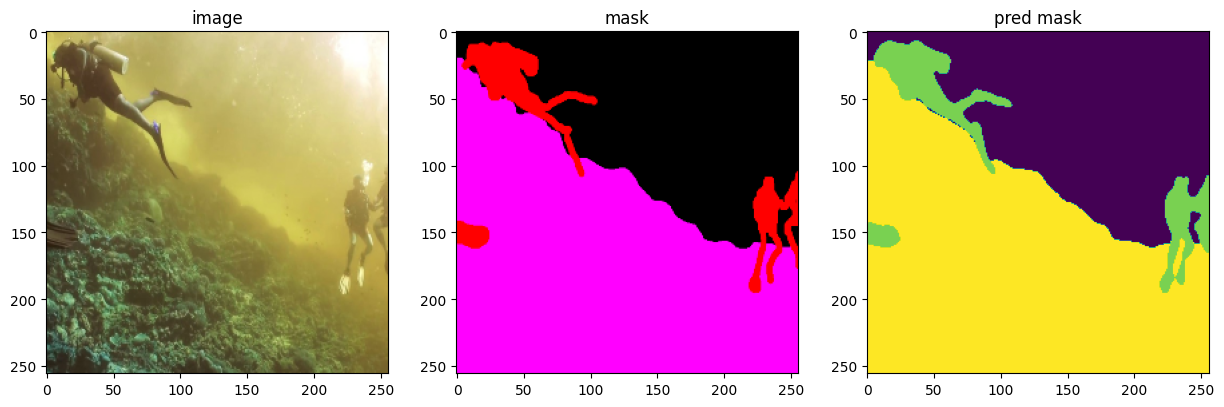

In [23]:
sample = random.randint(0, len(image_data))
pre_mask = model.predict(preprocess_input(np.array([image_data[sample]])))
# pre_mask = pre_mask.squeeze(axis=0)

pre_mask = np.argmax(pre_mask, axis=3)[0,:,:]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(image_data[sample])

plt.subplot(1, 3, 2)
plt.title("mask")
plt.imshow(mask_data[sample])

plt.subplot(1, 3, 3)
plt.title("pred mask")
plt.imshow(pre_mask)


# mask to poly

In [24]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.load_model("/kaggle/working/res34_backbone_500epochs.hdf5")

In [25]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, None,      │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, None,      │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, None,      │      9,408 │ zero_padding2d[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, None,      │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, None,      │          0 │ bn0[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, None,      │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, None,      │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, None,      │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, None,      │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, None,      │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, None,      │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, None,      │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, None,      │      4,096 │ stage1_unit1_rel

 Total params: 24,457,171 (93.30 MB)

 Trainable params: 24,439,819 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

 Optimizer params: 2 (12.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


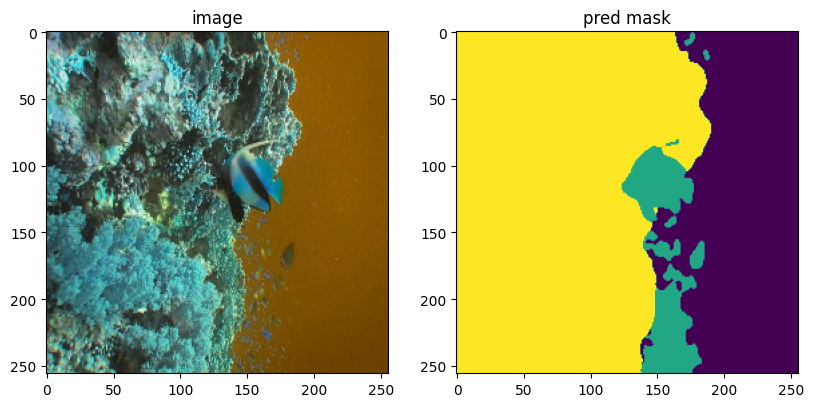

In [26]:
import random
sample = random.randint(0, len(image_data))

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

pre_mask1 = model.predict(preprocess_input(np.array([image_data[sample]])))
# pre_mask = pre_mask.squeeze(axis=0)

pre_mask = np.argmax(pre_mask1, axis=3)[0,:,:]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(image_data[sample])

plt.subplot(1, 3, 2)
plt.title("mask")
plt.imshow(mask_data[sample])

# plt.subplot(1, 3, 3)
plt.title("pred mask")
plt.imshow(pre_mask)

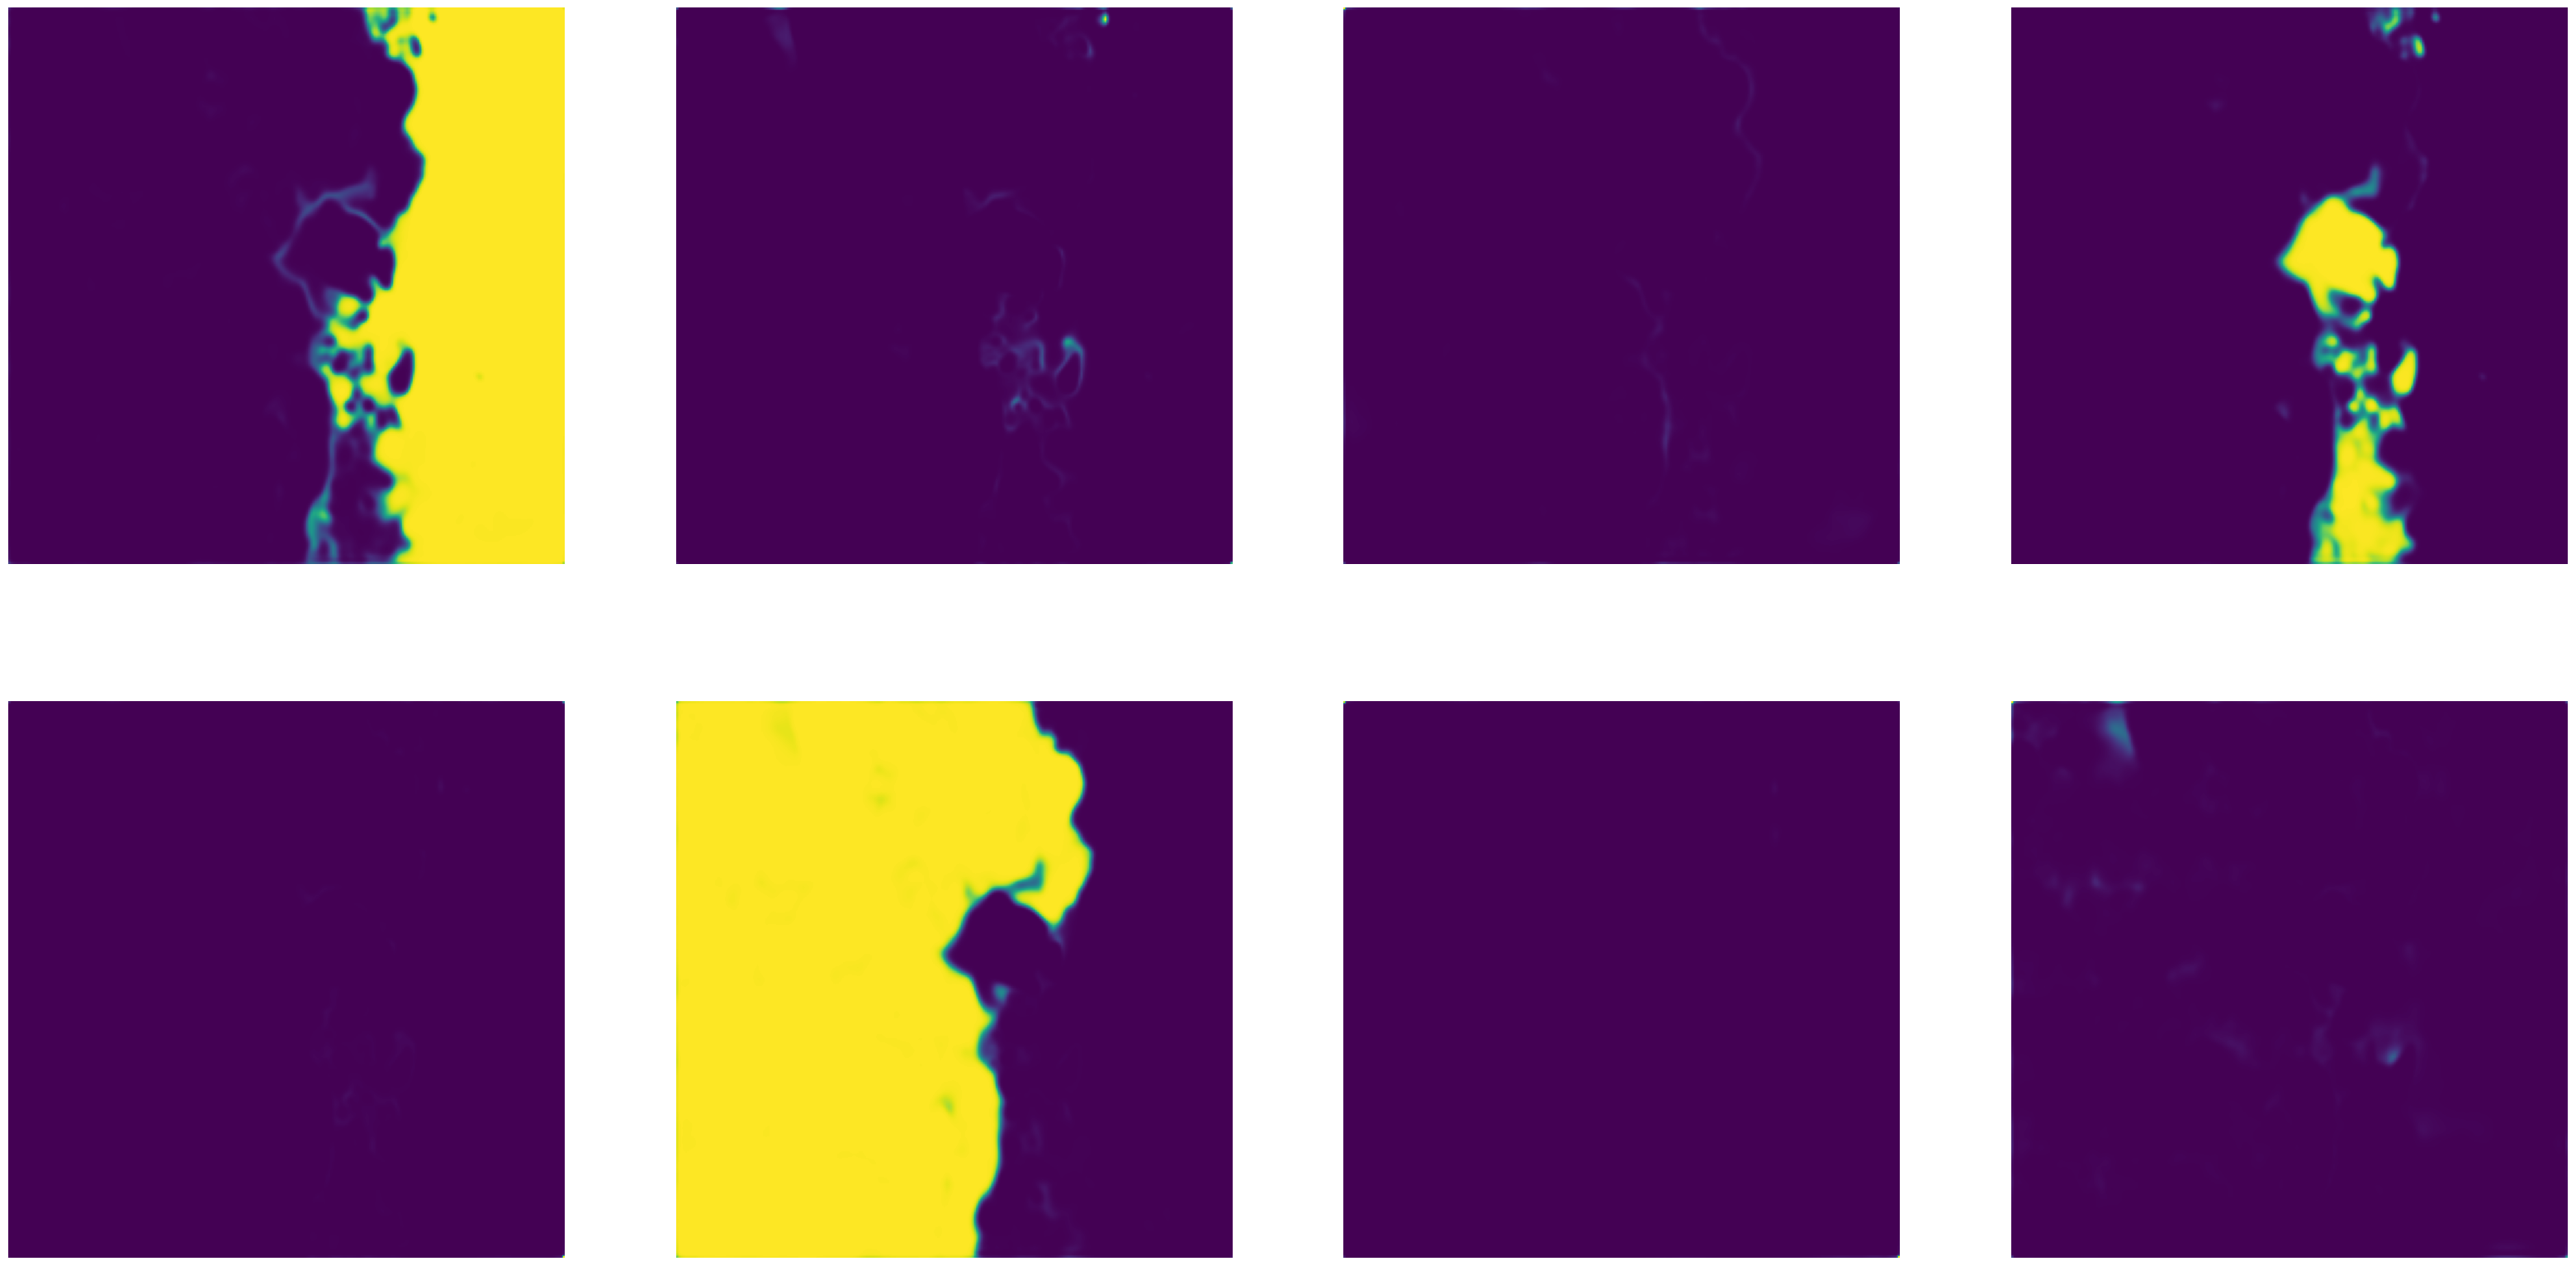

In [27]:
pre_mask2 = pre_mask1.squeeze(axis=0)

plt.figure(figsize=(40, 20))

plt.subplot(241)
plt.axis('off')
plt.imshow(pre_mask2[:,:,0])

plt.subplot(242)
plt.axis('off')
plt.imshow(pre_mask2[:,:,1])

plt.subplot(243)
plt.axis('off')
plt.imshow(pre_mask2[:,:,2])

plt.subplot(244)
plt.axis('off')
plt.imshow(pre_mask2[:,:,3])

plt.subplot(245)
plt.axis('off')
plt.imshow(pre_mask2[:,:,4])

plt.subplot(246)
plt.axis('off')
plt.imshow(pre_mask2[:,:,5])

plt.subplot(247)
plt.axis('off')
plt.imshow(pre_mask2[:,:,6])

plt.subplot(248)
plt.axis('off')
plt.imshow(pre_mask2[:,:,7])

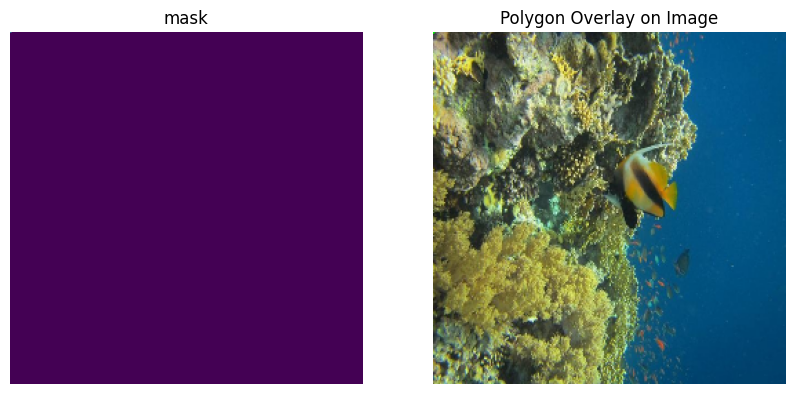

In [28]:
sd = pre_mask2[:,:,7]*12
pre_mask = sd.astype(np.uint8)
contours, _ = cv2.findContours(pre_mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the original image to draw polygons
original_image = (image_data[sample]*255).astype(np.uint8)
overlay_image = original_image.copy()

# Draw the contours as polygons on the overlay image
for contour in contours:
    # Approximate the contour to a polygon
    epsilon = 1
    polygon = cv2.approxPolyDP(contour, epsilon, closed=True)
    
    # Draw the polygon on the overlay image (in green color)
    cv2.polylines(overlay_image, [polygon], isClosed=True, color=(0, 255, 0), thickness=2)

# Convert BGR to RGB for correct color display in matplotlib
overlay_image = cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB)


# Plot the original image with the polygon overlay
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.imshow(pre_mask)
plt.axis('off')
plt.title('mask')

plt.subplot(1,2,2)
plt.imshow(overlay_image)
plt.axis('off')
plt.title('Polygon Overlay on Image')
plt.savefig(f'{sample}.png')
plt.show()

